In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
print(stopwords.words('english'))

train_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train_news.head()
test_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_news.head()
train_news.shape
test_news.shape
train_news.isnull().sum()
test_news.isnull().sum()
# replacing the null values with empty string
train_news = train_news.fillna(' ')
test_news = test_news.fillna(' ')
# merging the author name and news title
train_news['content'] = train_news['author']+' '+train_news['title']
test_news['content'] = test_news['author']+' '+test_news['title']
print(train_news['content'])
print(test_news['content'])

port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('^a-zA-Z', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

train_news['content'] = train_news['content'].apply(stemming)
test_news['content'] = test_news['content'].apply(stemming)
print(train_news['content'])
print(test_news['content'])

# Separating the data and label
X = train_news['content'].values
Y = train_news['label'].values
print(X)
print(Y)
Y.shape

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

# One-hot encoding for the output labels
Y = pd.get_dummies(Y).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=42)
print(f"Number of Training dataset: {X_train.shape[0]}\nNumber of Testing dataset: {X_test.shape[0]}")

# Model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense

model = Sequential()
model.add(Embedding(5000, 128, input_length=X.shape[1]))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# Training and evaluating the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluating the model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

# Make predictions
predictions = model.predict(X_test)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

130/130 [==============================] - 6s 50ms/step


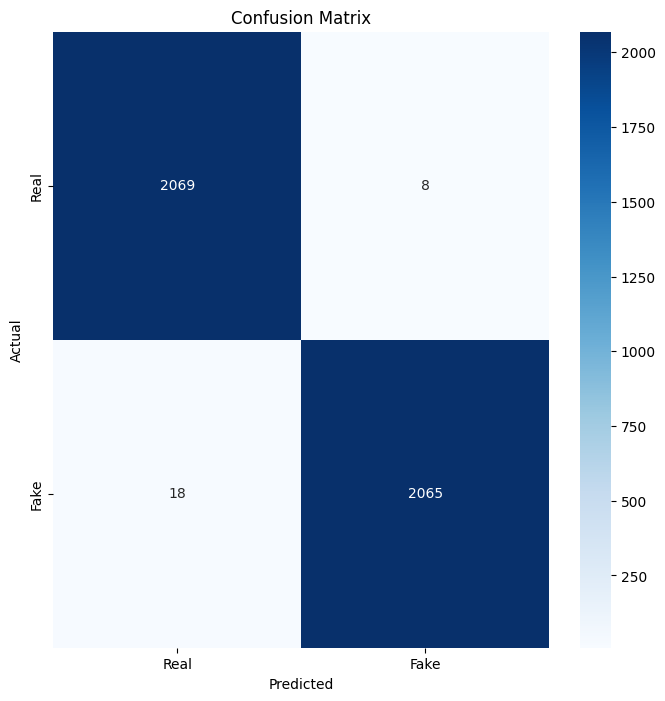

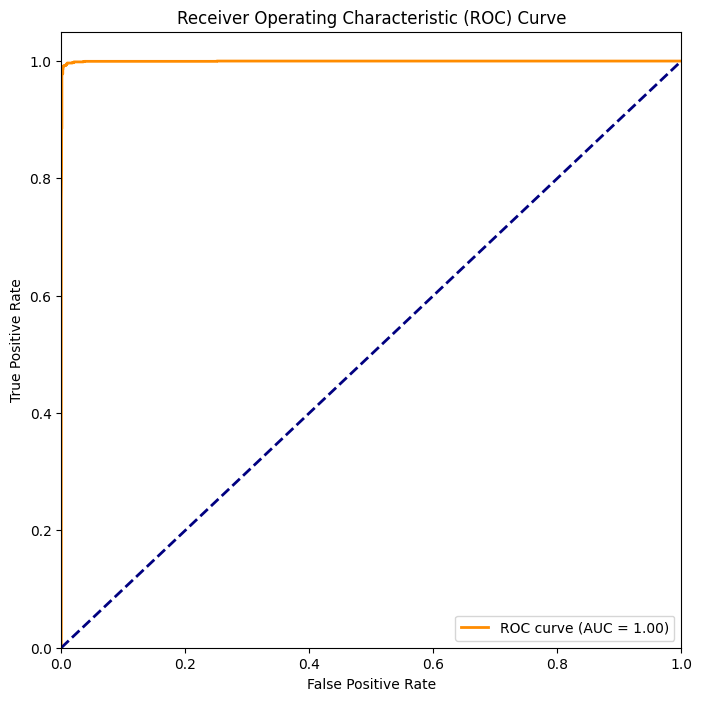

In [2]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Make predictions
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=-1)

# Confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test.argmax(axis=1), predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


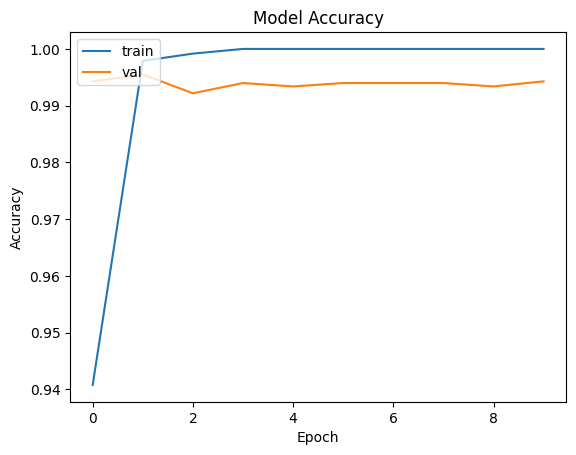

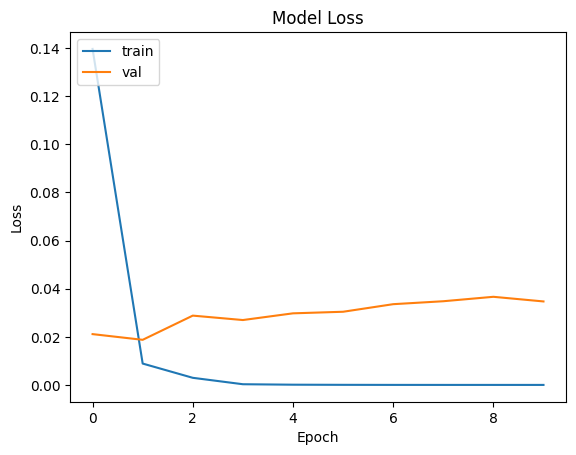

In [3]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

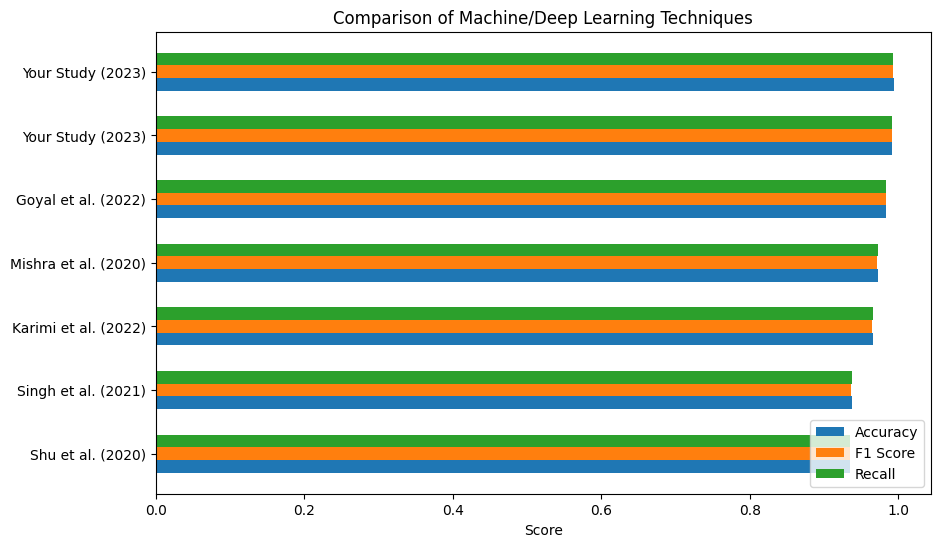

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
study = ['Shu et al. (2020)', 'Singh et al. (2021)', 'Karimi et al. (2022)', 'Mishra et al. (2020)', 'Goyal et al. (2022)', 'Your Study (2023)', 'Your Study (2023)']
technique = ['Random Forest', 'SVM + N-grams', 'CNN + LSTM', 'CNN + GRU', 'BERT', 'LSTM', 'BiLSTM']
accuracy = [0.935, 0.938, 0.966, 0.973, 0.984, 0.992, 0.994]
f1_score = [0.935, 0.937, 0.965, 0.972, 0.983, 0.992, 0.9935]
recall = [0.935, 0.938, 0.966, 0.973, 0.984, 0.992, 0.993]

# Define the colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the accuracy bars
plt.barh(np.arange(len(study))-0.2, accuracy, height=0.2, color=colors[0], label='Accuracy')

# Plot the F1 score bars
plt.barh(np.arange(len(study)), f1_score, height=0.2, color=colors[1], label='F1 Score')

# Plot the recall bars
plt.barh(np.arange(len(study))+0.2, recall, height=0.2, color=colors[2], label='Recall')

# Add the labels and legend
plt.yticks(np.arange(len(study)), study)
plt.xlabel('Score')
plt.title('Comparison of Machine/Deep Learning Techniques')
plt.legend(loc='lower right')

# Show the plot
plt.show()
